In [1]:
import pickle

# load data
with (open('/kaggle/input/norm-data-no-duplicates/norm_data_no_duplicates.pkl', "rb")) as openfile:
     norm_data = pickle.load(openfile)

In [2]:
norm_data['action'] = norm_data['action'].fillna(value=-1) # fill all none actions with -1

In [3]:
norm_data = norm_data[norm_data.action != -1] # remove data with actions == -1

In [4]:
norm_data['action'].unique() # get unique values of actions

array([ 4,  0,  1,  8,  3,  5,  9,  2,  6,  7, 10])

In [5]:
norm_data.shape # get shape of data

(1245518, 5)

In [6]:
norm_data2 = norm_data # copy

In [7]:
norm_data3 = norm_data # copy

In [8]:
norm_data2.head() # view data

,observation,action,state_norm,action_norm,behaviour_norm
674523,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,2,0,2
1343284,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0,2,2,1
595471,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,2,0,2
1602706,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,2,2,2
782150,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,2,0,2


In [9]:
import numpy as np

# convert data to float

obs = np.array(list(norm_data['observation']), dtype=np.float32)
action1 = np.array(list(norm_data['action']), dtype=np.int)
behav_norm1 = np.array(list(norm_data['behaviour_norm']), dtype=np.int)
action_norm1 = np.array(list(norm_data['action_norm']), dtype=np.int)
state_norm1 = np.array(list(norm_data['state_norm']), dtype=np.int)

/tmp/ipykernel_20/3118508101.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  action1 = np.array(list(norm_data['action']), dtype=np.int)
/tmp/ipykernel_20/3118508101.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprec

In [10]:
# reshape data

action1 = action1.reshape(-1,1)
behav_norm1 = behav_norm1.reshape(-1,1)
action_norm1 = action_norm1.reshape(-1,1)
state_norm1 = state_norm1.reshape(-1,1)

In [11]:
final_data  = np.concatenate((action1, behav_norm1, action_norm1, state_norm1), axis=1) # concatenate reshaped data

In [12]:
final_data # view final data

array([[4, 2, 0, 2],
       [0, 1, 2, 2],
       [4, 2, 0, 2],
       ...,
       [7, 2, 1, 0],
       [9, 2, 1, 0],
       [7, 2, 1, 0]])

In [13]:
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import numpy as np

# split data into train and test set

X_train, X_test, y_train, y_test = train_test_split(obs, final_data, test_size=0.30, random_state=2023,
                                                    stratify=final_data)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [14]:
X_train.shape # view shape of train set

(871862, 171)

In [15]:
import torch as T
import torch

# create custom dataset for dataloaders

class CustomDataset(T.utils.data.Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.from_numpy(x_data)
        self.y_data = torch.from_numpy(y_data)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x_data = self.x_data[idx]
        y_data = self.y_data[idx]
        return x_data, y_data[0], y_data[1], y_data[2], y_data[3]  # as a tuple

In [16]:
sets = {
    'train': (X_train, y_train), 'test': (X_test, y_test)
}

# create train and test dataset for pytorch

datasets = {
    x: CustomDataset(sets[x][0], sets[x][1]) for x in sets.keys()
}


 # create dataloaders with batch size 128
    
dataloaders = {
    x: DataLoader(datasets[x], batch_size=128) for x in sets.keys()
}

In [17]:
import torch.nn.functional as F

# create norm aware algorithm model class

class MultiOutputNormNet(torch.nn.Module):
    def __init__(self, num_classes1, num_classes2):
        super(MultiOutputNormNet, self).__init__()

        self.fc1 = torch.nn.Linear(171, 256) # fully connected layer
        self.act = nn.ReLU() # relu activation
        self.fc2 = torch.nn.Linear(256, 512) # fully connected layer
        self.act2 = nn.ReLU()
        self.fc21 = torch.nn.Linear(512, 256) # fully connected layer
        self.act3 = nn.ReLU()
        self.dropout = nn.Dropout(0.20) # 20% dropout
        self.fc3 = torch.nn.Linear(256, num_classes1) # output action
        self.fc4 = torch.nn.Linear(256, num_classes2) # output behaviour norm
        self.fc5 = torch.nn.Linear(256, num_classes2) # output action norm
        self.fc6 = torch.nn.Linear(256, num_classes2) # output state norm      

        # forward pass
    def forward(self, x):
        output_1 = self.act(self.fc1(x))
        output_2 = self.act2(self.fc2(output_1))
        output_3 = self.act3(self.fc21(output_2))
        output_3 = self.dropout(output_3)
        output_4 = self.fc3(output_3)
        output_5 = self.fc4(output_3)
        output_6 = self.fc5(output_3)
        output_7 = self.fc6(output_3)
        return output_4, output_5, output_6, output_7 # return output

In [18]:
model = MultiOutputNormNet(11, 3) # create instance of model

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device) # move model to device
lr = 1e-3  # set learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # define optimizer

# define loss function for each predictions
loss_fn_1 = torch.nn.CrossEntropyLoss().to(device)
loss_fn_2 = torch.nn.CrossEntropyLoss().to(device)
loss_fn_3 = torch.nn.CrossEntropyLoss().to(device)
loss_fn_4 = torch.nn.CrossEntropyLoss().to(device)
epochs = 20

In [20]:
# lists to store train loss and accuracies

train_overall_loss = []
train_action_accuracy = []
train_behav_norm_accuracy = []
train_action_norm_accuracy = []
train_state_norm_accuracy = []

In [21]:
# lists to store test accuracies

test_action_accuracy = []
test_behav_norm_accuracy = []
test_action_norm_accuracy = []
test_state_norm_accuracy = []

In [22]:
from sklearn.metrics import accuracy_score


# define train function

def train():
    overall_loss = 0.
    action_accuracy = 0.
    behav_accuracy = 0.
    action_norm_accuracy = 0.
    state_accuracy = 0.


    for data, action, behav_norm, action_norm, state_norm in dataloaders['train']: # iterate over dataloaders
        optimizer.zero_grad()

        data, action, behav_norm, action_norm, state_norm = data.to(device), action.to(device), behav_norm.to(device), action_norm.to(device), state_norm.to(device)
        
        output_1, output_2, output_3, output_4 = model(data) # pass data through model
        
        # calculate losses for outputs
        loss_1 = loss_fn_1(output_1, action) 
        loss_2 = loss_fn_2(output_2, behav_norm)
        loss_3 = loss_fn_2(output_3, action_norm)
        loss_4 = loss_fn_2(output_4, state_norm)

        loss = loss_1 + loss_2 + loss_3 + loss_4 # get sum of loss

        overall_loss += loss.item()

        # calculate accuracy for actions
        action_accuracy += accuracy_score(action.cpu().detach().numpy(),
                                            torch.argmax(output_1, dim=1).cpu().detach().numpy())
        
        # calculate accuracy for behaviour norm
        behav_accuracy += accuracy_score(behav_norm.cpu().detach().numpy(),
                                              torch.argmax(output_2, dim=1).cpu().detach().numpy())
        
        # calculate accuracy for action norm
        action_norm_accuracy += accuracy_score(action_norm.cpu().detach().numpy(),
                                            torch.argmax(output_3, dim=1).cpu().detach().numpy())
        
        # calculate accuracy for state norm
        state_accuracy += accuracy_score(state_norm.cpu().detach().numpy(),
                                              torch.argmax(output_4, dim=1).cpu().detach().numpy())

        loss.backward() # backward pass
        optimizer.step() 
    
    # calculate average loss and accuracies over length of dataloader
    overall_loss = overall_loss / len(dataloaders['train'])
    train_overall_loss.append(overall_loss)
    action_accuracy = action_accuracy / len(dataloaders['train'])
    train_action_accuracy.append(action_accuracy)
    behav_accuracy = behav_accuracy / len(dataloaders['train'])
    train_behav_norm_accuracy.append(behav_accuracy)
    action_norm_accuracy = action_norm_accuracy / len(dataloaders['train'])
    train_action_norm_accuracy.append(action_norm_accuracy)
    state_accuracy = state_accuracy / len(dataloaders['train'])
    train_state_norm_accuracy.append(state_accuracy)
    
    # print average accuracies over length of dataloader
    print('train action accuracy :', action_accuracy)
    print('train behaviour norm accuracy :', behav_accuracy)
    print('train action norm accuracy :', action_norm_accuracy)
    print('train state norm accuracy :',state_accuracy)

In [23]:
# define test function

def eval():
    model.eval() # set model to evaluation mode

    action_accuracy = 0.
    behav_accuracy = 0.
    action_norm_accuracy = 0.
    state_accuracy = 0.

    with torch.no_grad():
        for data, action, behav_norm, action_norm, state_norm in dataloaders['test']:
            data, action, behav_norm, action_norm, state_norm = data.to(device), action.to(device), behav_norm.to(device), action_norm.to(device), state_norm.to(device)
            

            output_1, output_2, output_3, output_4 = model(data) # pass data through model
            
            # calculate accuracy for actions
            action_accuracy += accuracy_score(action.cpu().detach().numpy(),
                                            torch.argmax(output_1, dim=1).cpu().detach().numpy())
            
            # calculate accuracy for behaviour norm
            behav_accuracy += accuracy_score(behav_norm.cpu().detach().numpy(),
                                              torch.argmax(output_2, dim=1).cpu().detach().numpy())
            
            # calculate accuracy for action norm
            action_norm_accuracy += accuracy_score(action_norm.cpu().detach().numpy(),
                                            torch.argmax(output_3, dim=1).cpu().detach().numpy())
            
            # calculate accuracy for state norm
            state_accuracy += accuracy_score(state_norm.cpu().detach().numpy(),
                                              torch.argmax(output_4, dim=1).cpu().detach().numpy())
        
        
        # calculate average loss and accuracies over length of dataloader
        action_accuracy = action_accuracy / len(dataloaders['test'])
        test_action_accuracy.append(action_accuracy)
        behav_accuracy = behav_accuracy / len(dataloaders['test'])
        test_behav_norm_accuracy.append(behav_accuracy)
        action_norm_accuracy = action_norm_accuracy / len(dataloaders['test'])
        test_action_norm_accuracy.append(action_norm_accuracy)
        state_accuracy = state_accuracy / len(dataloaders['test'])
        test_state_norm_accuracy.append(state_accuracy)
        
         # print average accuracies over length of dataloader
        print('test action accuracy :', action_accuracy)
        print('test behaviour norm accuracy :', behav_accuracy)
        print('test action norm accuracy :', action_norm_accuracy)
        print('test state norm accuracy :', state_accuracy)

    model.train()  # set model to train mode

In [24]:
# iterate over epochs and call train and test function

for epoch in range(20):
    print('Epoch ;', epoch)
    train()
    eval()

Epoch ; 0
train action accuracy : 0.6763752453459038
train behaviour norm accuracy : 0.9825755560041104
train action norm accuracy : 0.8275295179666601
train state norm accuracy : 0.9990354796682326
test action accuracy : 0.7223209189497718
test behaviour norm accuracy : 0.9854996075913242
test action norm accuracy : 0.8557202482876712
test state norm accuracy : 1.0
Epoch ; 1
train action accuracy : 0.729945690883191
train behaviour norm accuracy : 0.985537929389313
train action norm accuracy : 0.8582872120413867
train state norm accuracy : 0.999982796902525
test action accuracy : 0.7410075984589041
test behaviour norm accuracy : 0.9861310288242009
test action norm accuracy : 0.8637289526255707
test state norm accuracy : 0.9999946489726027
Epoch ; 2
train action accuracy : 0.7445962734607773
train behaviour norm accuracy : 0.9864595906461365
train action norm accuracy : 0.8664304362807463
train state norm accuracy : 0.99999541250734
test action accuracy : 0.7486452982305937
test behavi

In [25]:
# lists to store test labels and predictions

behav_label = []
behav_predict = []
action_norm_label = []
action_norm_predict = []
action_label = []
action_predict = []
state_norm_label = []
state_norm_predict = []

with torch.no_grad():
        for data, action, behav_norm, action_norm, state_norm in dataloaders['test']:
            data, action, behav_norm, action_norm, state_norm = data.to(device), action.to(device), behav_norm.to(device), action_norm.to(device), state_norm.to(device)
            

            output_1, output_2, output_3, output_4 = model(data)
            
            # extract training labels and get predictions from model
            behav_label.extend(behav_norm.cpu().detach().numpy())
            behav_predict.extend(torch.argmax(output_2, dim=1).cpu().detach().numpy())
            action_label.extend(action.cpu().detach().numpy())
            action_predict.extend(torch.argmax(output_1, dim=1).cpu().detach().numpy())
            action_norm_label.extend(action_norm.cpu().detach().numpy())
            action_norm_predict.extend(torch.argmax(output_3, dim=1).cpu().detach().numpy())
            state_norm_label.extend(state_norm.cpu().detach().numpy())
            state_norm_predict.extend(torch.argmax(output_4, dim=1).cpu().detach().numpy())


In [26]:
from sklearn.metrics import classification_report

In [27]:
# the precision, recall, f1_score for behaviour norm labels and predictions

behaviour_norm_cr = classification_report(behav_label, behav_predict)
print(behaviour_norm_cr)

              precision    recall  f1-score   support

           0       0.69      0.55      0.61      6974
           1       0.94      0.97      0.96     54626
           2       1.00      1.00      1.00    312056

    accuracy                           0.99    373656
   macro avg       0.88      0.84      0.86    373656
weighted avg       0.99      0.99      0.99    373656



In [28]:
# the precision, recall, f1_score for action norm labels and predictions


action_norm_cr = classification_report(action_norm_label, action_norm_predict)
print(action_norm_cr)

              precision    recall  f1-score   support

           0       0.71      0.74      0.72     64448
           1       0.85      0.80      0.82    106760
           2       0.92      0.95      0.94    202448

    accuracy                           0.87    373656
   macro avg       0.83      0.83      0.83    373656
weighted avg       0.87      0.87      0.87    373656



In [29]:
# the precision, recall, f1_score for action labels and predictions

action_cr = classification_report(action_label, action_predict)
print(action_cr)

              precision    recall  f1-score   support

           0       0.73      0.76      0.74     70827
           1       0.73      0.71      0.72     76929
           2       0.81      0.90      0.85     25364
           3       0.93      0.94      0.94     29328
           4       0.60      0.67      0.63     33099
           5       0.63      0.60      0.61     31349
           6       0.92      0.89      0.91     22863
           7       0.88      0.88      0.88     25726
           8       0.78      0.73      0.75     31427
           9       0.69      0.57      0.62     18161
          10       0.60      0.57      0.58      8583

    accuracy                           0.75    373656
   macro avg       0.75      0.75      0.75    373656
weighted avg       0.75      0.75      0.75    373656



In [30]:
# the precision, recall, f1_score for state norm labels and predictions

state_norm_cr = classification_report(state_norm_label, state_norm_predict)
print(state_norm_cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7232
           1       1.00      1.00      1.00      7768
           2       1.00      1.00      1.00    358656

    accuracy                           1.00    373656
   macro avg       1.00      1.00      1.00    373656
weighted avg       1.00      1.00      1.00    373656



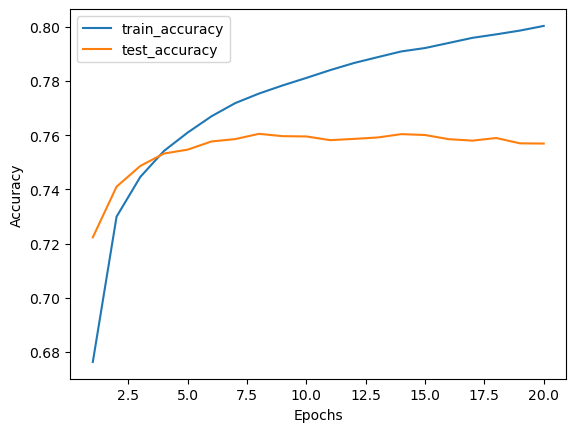

In [31]:
import matplotlib.pyplot as plt

# plot of Train and Test Accuracy for Action Predictions across epochs

epochs = range(1, 21)
# plt.title('Train and Test Accuracy for Action Predictions')
plt.plot(epochs, train_action_accuracy, label = 'train_accuracy')
plt.plot(epochs, test_action_accuracy, label = 'test_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('action_accuracy')

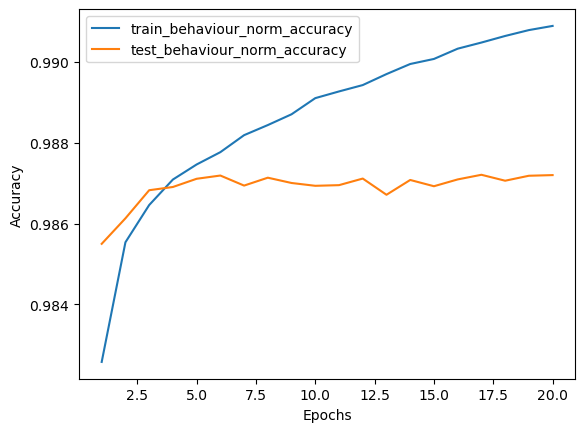

In [32]:
# plot of Train and Test Accuracy for behaviour norm Predictions across epochs


epochs = range(1, 21)
# plt.title('Train and Test Accuracy for Behaviour Norm Predictions')
plt.plot(epochs, train_behav_norm_accuracy, label = 'train_behaviour_norm_accuracy')
plt.plot(epochs, test_behav_norm_accuracy, label = 'test_behaviour_norm_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('behaviour_accuracy')

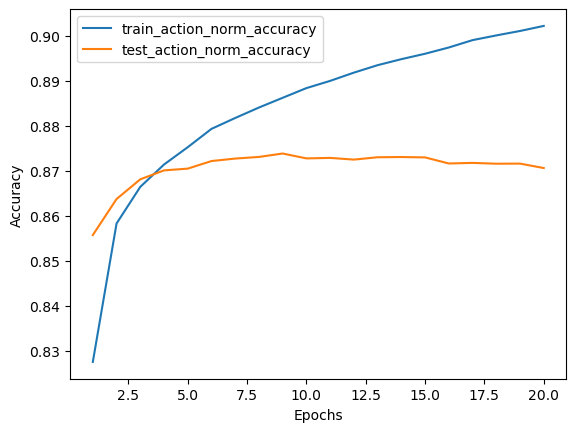

In [33]:
# plot of Train and Test Accuracy for Action norm Predictions across epochs

epochs = range(1, 21)
# plt.title('Train and Test Accuracy for Action Norm Predictions')
plt.plot(epochs, train_action_norm_accuracy, label = 'train_action_norm_accuracy')
plt.plot(epochs, test_action_norm_accuracy, label = 'test_action_norm_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('action_norm_accuracy')

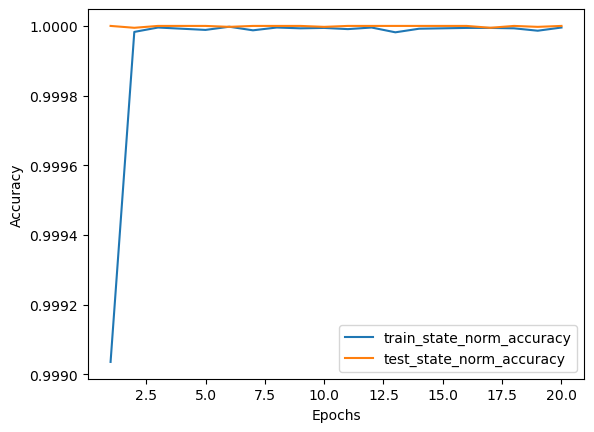

In [34]:
# plot of Train and Test Accuracy for state norm Predictions across epochs

epochs = range(1, 21)
# plt.title('Train and Test Accuracy for State Norm Predictions')
plt.plot(epochs, train_state_norm_accuracy, label = 'train_state_norm_accuracy')
plt.plot(epochs, test_state_norm_accuracy, label = 'test_state_norm_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('state_norm_accuracy')

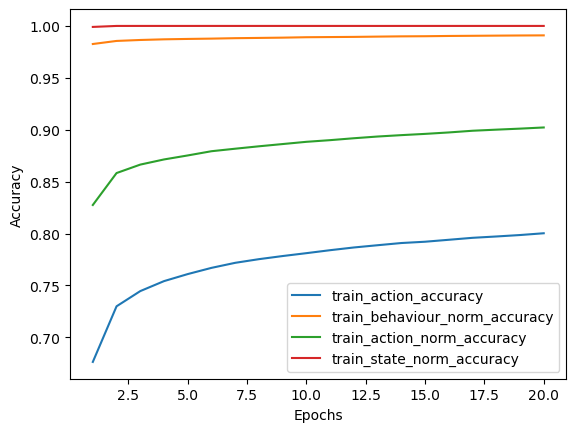

In [35]:
# final plot for train accuracies

epochs = range(1, 21)
# plt.title('Train Accuracies for Predictions')
plt.plot(epochs, train_action_accuracy, label = 'train_action_accuracy')
plt.plot(epochs, train_behav_norm_accuracy, label = 'train_behaviour_norm_accuracy')
plt.plot(epochs, train_action_norm_accuracy, label = 'train_action_norm_accuracy')
plt.plot(epochs, train_state_norm_accuracy, label = 'train_state_norm_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('train_accuracy')

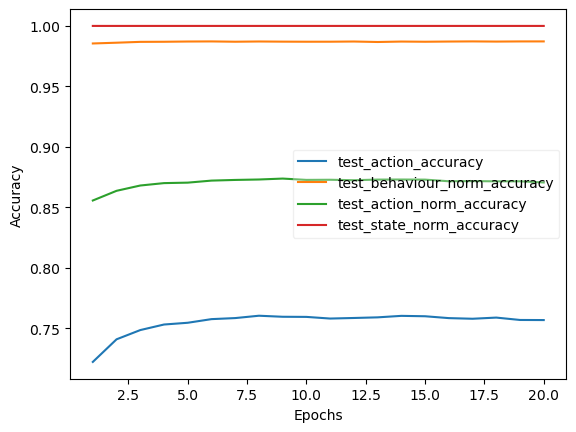

In [36]:
# final plot for test accuracies

epochs = range(1, 21)
# plt.title('Test Accuracies for Predictions')
plt.plot(epochs, test_action_accuracy, label = 'test_action_accuracy')
plt.plot(epochs, test_behav_norm_accuracy, label = 'test_behaviour_norm_accuracy')
plt.plot(epochs, test_action_norm_accuracy, label = 'test_action_norm_accuracy')
plt.plot(epochs, test_state_norm_accuracy, label = 'test_state_norm_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'center right', framealpha = 0.3)
plt.savefig('test_accuracy')

In [38]:
PATH = './norm_learning_model.pth'  
torch.save(model.state_dict(), PATH)  # save model